本代码主要参考官方baseline:
https://tianchi.aliyun.com/competition/entrance/531858/forum

In [1]:
## 基础工具
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 数据处理
from sklearn import preprocessing

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

## 模型预测的
import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:

## 1) 载入训练集和测试集；
Train_data = pd.read_csv('used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('used_car_testB_20200421.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


<AxesSubplot:>

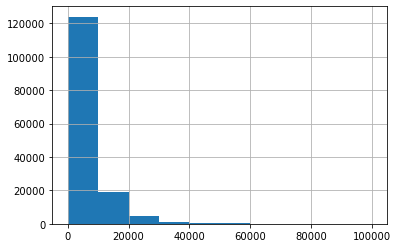

In [3]:
Train_data.price.hist()

In [3]:
#预处理函数
def reduce_mem(df): 
    """ iterate through all the columns of a dataframe and modify the data type  to reduce memory usage.             """ 
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem)) 
    df1 = df.copy() 
    for col in df.columns: 
        col_type = df[col].dtype 
         
        if col_type != object: 
            c_min = df[col].min() 
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int': 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: 
                    df[col] = df[col].astype(np.int8) 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: 
                    df[col] = df[col].astype(np.int16) 
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: 
                    df[col] = df[col].astype(np.int32) 
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max: 
                    df[col] = df[col].astype(np.int64)   
            else: 
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: 
                    df[col] = df[col].astype(np.float16) 
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: 
                    df[col] = df[col].astype(np.float32) 
                else: 
                    df[col] = df[col].astype(np.float64) 
        #Treatment for category columns
        else: 
            df[col] = df[col].astype('category') 
 
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem)) 
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem)) 
    if end_mem > start_mem:
        print(f'Memory usage increases! Return the original df.')
        return df1
    return df 

In [4]:
Train_data = reduce_mem(Train_data)
TestA_data = reduce_mem(TestA_data)

Memory usage of dataframe is 35.48 MB
Memory usage after optimization is: 9.73 MB
Decreased by 72.6%
Memory usage of dataframe is 11.44 MB
Memory usage after optimization is: 3.05 MB
Decreased by 73.3%


In [6]:
## 通过.head() 简要浏览读取数据的形式
display(Train_data.head())
display(TestA_data.head())

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.31250,5.234375,0.137939,1.380859,-1.421875,0.264893,0.121033,0.135742,0.026596,0.020584,-4.902344,2.095703,-1.030273,-1.722656,0.245483
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.68750,4.492188,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000,-4.507812,1.286133,-0.501953,-2.437500,-0.478760
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,0.0,5019,0,0,20160308,42.15625,-3.095703,-0.721191,1.466797,1.009766,0.236572,0.000241,0.105347,0.046234,0.094543,3.619141,-0.280518,-2.019531,0.979004,0.803223
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,0.0,1505,0,0,20160310,43.90625,-3.244141,-0.766602,1.276367,-1.065430,0.261475,0.000000,0.120300,0.046783,0.035400,2.998047,-1.406250,-1.020508,-1.349609,-0.200562
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,-,1776,0,0,20160309,45.37500,3.373047,-0.965332,-2.447266,0.624512,0.261719,0.090820,0.000000,0.079651,0.073608,-3.951172,-0.433350,0.918945,1.634766,1.027344
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,0.0,26,0,0,20160314,42.78125,4.035156,-0.217407,1.708984,1.119141,0.236084,0.101807,0.098938,0.026825,0.096619,-2.847656,2.800781,-2.525391,1.077148,0.461670
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,0.0,738,0,0,20160306,43.65625,-3.134766,-1.133789,0.470215,0.134033,0.257080,0.000000,0.066711,0.057770,0.068848,2.839844,-1.660156,-0.924316,0.199463,0.450928


In [5]:
#提取数值类型特征列名
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')
Index([], dtype='object')


In [6]:
Train_data['notRepairedDamage'].replace('-',-1,inplace=True)
TestA_data['notRepairedDamage'].replace('-',-1,inplace=True)

In [7]:
date_features = ['regDate', 'creatDate']
numeric_features = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]
categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 
                        'notRepairedDamage', 'regionCode',]

In [8]:
from tqdm import tqdm
#时间特征处理
def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]

def num_to_date(df,date_cols):
    for f in tqdm(date_cols):
        df[f] = pd.to_datetime(df[f].astype('str').apply(date_proc))
        df[f + '_year'] = df[f].dt.year
        df[f + '_month'] = df[f].dt.month
        df[f + '_day'] = df[f].dt.day
        df[f + '_dayofweek'] = df[f].dt.dayofweek
    return df
Train_data = num_to_date(Train_data,date_features)
TestA_data = num_to_date(TestA_data,date_features)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.62it/s]


时间特征相似，所以可以采用

In [9]:
from scipy.stats import mode
#类别统计
def sta_cate(df,cols):
    sta_df = pd.DataFrame(columns = ['column','nunique','miss_rate','most_value','most_value_counts','max_value_counts_rate'])
    for col in cols:
        count = df[col].count()
        nunique = df[col].nunique()
        miss_rate = (df.shape[0] - count) / df.shape[0]
        most_value = df[col].value_counts().index[0]
        most_value_counts = df[col].value_counts().values[0]
        max_value_counts_rate = most_value_counts / df.shape[0]
        
        sta_df = sta_df.append({'column':col,'nunique':nunique,'miss_rate':miss_rate,'most_value':most_value,
                                'most_value_counts':most_value_counts,'max_value_counts_rate':max_value_counts_rate},ignore_index=True)
    return sta_df 

In [10]:
sta_cate(Train_data,categorical_features)

,column,nunique,miss_rate,most_value,most_value_counts,max_value_counts_rate
0,name,99662,0.000000,387,282,0.001880
1,model,248,0.000007,0.0,11762,0.078413
2,brand,40,0.000000,0,31480,0.209867
3,bodyType,8,0.030040,0.0,41420,0.276133
4,fuelType,7,0.057867,0.0,91656,0.611040
5,gearbox,2,0.039873,0.0,111623,0.744153
6,notRepairedDamage,3,0.000000,0.0,111361,0.742407
7,regionCode,7905,0.000000,419,369,0.002460


In [11]:
sta_cate(TestA_data,categorical_features)

,column,nunique,miss_rate,most_value,most_value_counts,max_value_counts_rate
0,name,37536,0.00000,387,94,0.00188
1,model,245,0.00000,0.0,3772,0.07544
2,brand,40,0.00000,0,10473,0.20946
3,bodyType,8,0.03008,0.0,13765,0.27530
4,fuelType,7,0.05848,0.0,30489,0.60978
5,gearbox,2,0.03936,0.0,37131,0.74262
6,notRepairedDamage,3,0.00000,0.0,37224,0.74448
7,regionCode,6998,0.00000,419,120,0.00240


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def cate_encoder(df,df_test,cols):
    le = LabelEncoder()
    ohe = OneHotEncoder(sparse=False,categories ='auto')
    
    for col in cols:
        print(col+':')
        print(set(df[col]))
        print(set(df_test[col]))
        
        le = le.fit(df[col])
        integer_encoded = le.transform(df[col])
        integer_encoded_test = le.transform(df_test[col])

        # binary encode
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
        ohe = ohe.fit(integer_encoded)
        
        onehot_encoded = ohe.transform(integer_encoded)
        onehot_encoded_df = pd.DataFrame(onehot_encoded)
        onehot_encoded_df.columns = list(map(lambda x:str(x)+'_'+col,onehot_encoded_df.columns.values))

        onehot_encoded_test = ohe.transform(integer_encoded_test)
        onehot_encoded_test_df = pd.DataFrame(onehot_encoded_test)
        onehot_encoded_test_df.columns = list(map(lambda x:str(x)+'_'+col,onehot_encoded_test_df.columns.values))
        
        df =  pd.concat([df,onehot_encoded_df], axis=1)
        df_test =  pd.concat([df_test,onehot_encoded_test_df], axis=1)
    
    return df,df_test
cate_cols = ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage']
Train_data[cate_cols] = Train_data[cate_cols].fillna(-1)
TestA_data[cate_cols] = TestA_data[cate_cols].fillna(-1)
Train_data,TestA_data = cate_encoder(Train_data,TestA_data,cate_cols)


bodyType:
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, -1.0}
fuelType:
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, -1.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, -1.0}
gearbox:
{0.0, 1.0, -1.0}
{0.0, 1.0, -1.0}
notRepairedDamage:
{'1.0', '0.0', -1}
{'1.0', '0.0', -1}


TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

In [ ]:
plt.figure(figsize=(15, 15))
i = 1
for col in numeric_features:
    plt.subplot(5, 4, i)
    i += 1
    sns.distplot(Train_data[col], label='train', color='r', hist=False)
    sns.distplot(TestA_data[col], label='test', color='b', hist=False)
plt.tight_layout()
plt.show()

In [13]:
tr = Train_data.copy()
te = TestA_data.copy()

In [14]:
Train_data.kilometer

0         12.5
1         15.0
2         12.5
3         15.0
4          5.0
          ... 
149995    15.0
149996    10.0
149997     6.0
149998    15.0
149999    12.5
Name: kilometer, Length: 150000, dtype: float16

In [ ]:
plt.figure(figsize=(15, 15))
i = 1
for col in numeric_features:
    plt.subplot(5, 4, i)
    i += 1
    sns.distplot(Train_data[col], label='train', color='r', hist=False)
    sns.distplot(TestA_data[col], label='test', color='b', hist=False)
plt.tight_layout()
plt.show()

# 特征工程

In [15]:
# 训练集和测试集放在一起，方便构造特征
Train_data['train']=1
TestA_data['train']=0

data = pd.concat([Train_data, TestA_data], ignore_index=True, sort=False)

In [16]:
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着（不管或者作为一个单独类别）。
# XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
data['used_time'].isnull().sum()

0

In [17]:
## 由于power 特征的分布特性，这里对于其进行log变化
data['power'] = np.log1p(data['power'])

In [18]:
#聚类类别特征
from sklearn.cluster import KMeans
kms = KMeans(n_clusters=5)
k_t = kms.fit_predict(data[numeric_features])
d = k_t.tolist()
data['kmeans_type'] = d

In [19]:
import pickle
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD,PCA 

seed,n_comp = 2021,8 
fitting = True 
if fitting: 
    svd = TruncatedSVD(random_state=seed,n_components=n_comp).fit_transform(data[numeric_features]) 
    pca = PCA(n_components=n_comp, random_state=seed).fit(data[numeric_features]) 
#     umap = UMAP(n_components=n_comp, random_state=seed).fit(data[numeric_features]) 
    f = open('./input/svd','wb')
    pickle.dump(svd,f)
    f.close()

data[[f'svd_{i + 1}' for i in range(n_comp)]]= pd.DataFrame(svd)#,index=df.index 
print("*") 
p = pca.transform(data[numeric_features]) 
# u = umap.transform(df[num_cols]) 
data[[f'pca_{i + 1}' for i in range(n_comp)]]= pd.DataFrame(p) 
print('p is done') 
# df[[f'umap_{i + 1}' for i in range(n_comp)]]= pd.DataFrame(u) 
del p#,u

FileNotFoundError: [Errno 2] No such file or directory: './input/svd'

In [ ]:
# 交叉特征组合列表
ls =['bodyType','fuelType','offerType','regionCode','model','brand',
            'seller']
pair = []
seen = set()
for f1 in ls:
    for f2 in ls:
        if ((f1,f2) not in seen) and ((f1,f2) not in seen) and f1!=f2:
            pair.append([f1,f2])
            seen.add((f1,f2))
del ls

In [ ]:
# 计算某品牌的销售统计量，这种特征不能细粒度的统计，防止发生信息过多的泄露
train_gb = Train_data.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [ ]:
## 这部分就参考天才的代码了
from scipy.stats import entropy

feat_cols = []
def genPower(df,col='kilometer'):
    df[col+"_genFeat1"]=(df['kilometer'] > 5).astype(int)
    df[col+"_genFeat2"]=(df['kilometer']> 10).astype(int)
    df[col+"_genFeat3"]=(df['kilometer']> 15).astype(int)
    return df
data = genPower(data)

### count编码
for f in tqdm(['regDate_year','model', 'brand', 'regionCode']): #kmeans_type,pca,svd
    data[f + '_count'] = data[f].map(data[f].value_counts())
    feat_cols.append(f + '_count')

### 用数值特征对类别特征做统计刻画，随便挑了几个跟price相关性最高的匿名特征 ：Target-price编码
for f1 in tqdm(['model', 'brand', 'regionCode']):
    group = data.groupby(f1, as_index=False)
    for f2 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
        feat = group[f2].agg({
            '{}_{}_max'.format(f1, f2): 'max', '{}_{}_min'.format(f1, f2): 'min',
            '{}_{}_median'.format(f1, f2): 'median', '{}_{}_mean'.format(f1, f2): 'mean',
            '{}_{}_std'.format(f1, f2): 'std', '{}_{}_mad'.format(f1, f2): 'mad'
        })
        data = data.merge(feat, on=f1, how='left')
        feat_list = list(feat)
        feat_list.remove(f1)
        feat_cols.extend(feat_list)

# v系列交叉特征  （一维交叉） 
for f1 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
    data[f'{f1}_squared'] = data[f1]**2
    data[f'{f1}_log'] = np.log1p(data[f1])
    for f2 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
        if f1 != f2:
            data[f'{f1}_{f2}_add']  = data[f1]+data[f2]
            data[f'{f1}_{f2}_minus']  = data[f1]-data[f2]
            data[f'{f1}_{f2}_multi']  = data[f1]*data[f2]
            data[f'{f1}_{f2}_div']  = data[f1]/(data[f2]+0.0000001)

### 类别特征的二阶交叉   （类别二维特征交叉）
for f_pair in tqdm([['model', 'brand'], ['model', 'regionCode'], ['brand', 'regionCode']]):#+pair
    ### 共现次数
    data['_'.join(f_pair) + '_count'] = data.groupby(f_pair)['SaleID'].transform('count')
    
    ### nunique、熵
    data = data.merge(data.groupby(f_pair[0], as_index=False)[f_pair[1]].agg({
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]): 'nunique',
        '{}_{}_ent'.format(f_pair[0], f_pair[1]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[0], how='left')
    
    data = data.merge(data.groupby(f_pair[1], as_index=False)[f_pair[0]].agg({
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]): 'nunique',
        '{}_{}_ent'.format(f_pair[1], f_pair[0]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[1], how='left')
    
    ### 比例偏好
    data['{}_in_{}_prop'.format(f_pair[0], f_pair[1])] = data['_'.join(f_pair) + '_count'] / data[f_pair[1] + '_count']
    data['{}_in_{}_prop'.format(f_pair[1], f_pair[0])] = data['_'.join(f_pair) + '_count'] / data[f_pair[0] + '_count']
    
    feat_cols.extend([
        '_'.join(f_pair) + '_count',
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]), '{}_{}_ent'.format(f_pair[0], f_pair[1]),
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]), '{}_{}_ent'.format(f_pair[1], f_pair[0]),
        '{}_in_{}_prop'.format(f_pair[0], f_pair[1]), '{}_in_{}_prop'.format(f_pair[1], f_pair[0])
    ])

In [ ]:
#生成交叉列表
for f_pair in tqdm(pair[:]):#pair[:10]已经足够提分
    ### 共现次数
    data['_'.join(f_pair) + '_count'] = data.groupby(f_pair)['SaleID'].transform('count')
    data = data.merge(data.groupby(f_pair[0], as_index=False)[f_pair[1]].agg({
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]): 'nunique',
        '{}_{}_ent'.format(f_pair[0], f_pair[1]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[0], how='left')
    data = data.merge(data.groupby(f_pair[1], as_index=False)[f_pair[0]].agg({
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]): 'nunique',
        '{}_{}_ent'.format(f_pair[1], f_pair[0]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[1], how='left')
    feat_cols.extend([
        '_'.join(f_pair) + '_count',
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]), '{}_{}_ent'.format(f_pair[0], f_pair[1]),
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]), '{}_{}_ent'.format(f_pair[1], f_pair[0]),
        '{}_in_{}_prop'.format(f_pair[0], f_pair[1]), '{}_in_{}_prop'.format(f_pair[1], f_pair[0])
    ])

In [ ]:
#标识是否训练集
import pickle
import io
train = data[data['train']==1]
test = data[data['train']==0]

## 选择特征列
feature_cols = [col for col in data.columns if col not in ['SaleID','name','regDate','creatDate','bodyType','fuelType','offerType','regionCode','price','model','brand',
            'seller','train']]
#2021-04-29
feature_cols = [col for col in data.columns if col not in ['SaleID','name','regDate','creatDate','price','train']]
'''
fixe here to check fitting.
'''

feature_cols = [col for col in feature_cols if col not in date_features[1:]]

## 提前特征列，标签列构造训练样本和测试样本

X_data = train[feature_cols]
Y_data = train['price']

X_test  = test[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

In [ ]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [ ]:
from sklearn.model_selection import KFold

def cv_predict(model,X_data,Y_data,X_test,sub):

    oof_trn = np.zeros(X_data.shape[0])
    oof_val = np.zeros(X_data.shape[0])
    feature_importance_df = pd.DataFrame()
    ## 5折交叉验证方式
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    for idx, (trn_idx,val_idx) in enumerate(kf.split(X_data,Y_data)):
        print('--------------------- {} fold ---------------------'.format(idx))
        trn_x, trn_y = X_data.iloc[trn_idx].values, Y_data.iloc[trn_idx]
        val_x, val_y = X_data.iloc[val_idx].values, Y_data.iloc[val_idx]

        xgr.fit(trn_x,trn_y,eval_set=[(val_x, val_y)],eval_metric='mae',verbose=30,early_stopping_rounds=20,)

        oof_trn[trn_idx] = xgr.predict(trn_x)
        oof_val[val_idx] = xgr.predict(val_x)
        sub['price'] += xgr.predict(X_test.values) / kf.n_splits

        pred_trn_xgb=xgr.predict(trn_x)
        pred_val_xgb=xgr.predict(val_x)
        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_data.columns.to_list()
        fold_importance_df["importance"] = xgr.feature_importances_#(importance_type='gain')
        fold_importance_df["fold"] = idx
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)     
        print('trn mae:', mean_absolute_error(trn_y, oof_trn[trn_idx]))
        print('val mae:', mean_absolute_error(val_y, oof_val[val_idx]))
        if idx==0:
            break
    feature_importance_df.sort_values(by='importance',inplace=True)
    return model,oof_trn,oof_val,sub,feature_importance_df

In [ ]:
## 原始标签预测
sub2 = test[['SaleID']].copy()
sub2['price'] = 0

oof_trn = np.zeros(train.shape[0])
oof_val = np.zeros(train.shape[0])

## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

model2,oof_trn,oof_val,sub2,feature_importance_df = cv_predict(xgr,X_data,Y_data,X_test,sub2)

print('Train mae:',mean_squared_error(Y_data,oof_trn))
print('Val mae:', mean_squared_error(Y_data,oof_val))

In [ ]:
select = feature_importance_df
display(feature_importance_df[feature_importance_df['importance']>0].head(10))

In [ ]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.1],#
    }
    gbm = GridSearchCV(estimator, param_grid)

    gbm.fit(x_train, y_train)
    print(f"Best:  {gbm}" )

    return gbm

In [ ]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [ ]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))
    
print('Sta of label:')
Sta_inf(Y_data)

In [ ]:
col = list(set(X_data.columns))
len(col)

In [ ]:
print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data[col],Y_data)
subA_lgb = model_lgb_pre.predict(X_test[col])
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

In [ ]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train[col],y_train)
val_xgb = model_xgb.predict(x_val[col])
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data[col],Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

In [ ]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<10]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

In [ ]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb
sub_Weighted[sub_Weighted<10]=10
## 查看预测值的统计,判断和训练集是否接近
print('Sta of Predict lgb:')
Sta_inf(sub_Weighted)

In [ ]:
Sta_inf(Train_data.price)

In [ ]:
sub3 = test[['SaleID']].copy()
sub3['price'] = sub_Weighted
sub3.head()

In [ ]:
sub3['price'].hist()

In [ ]:
import time
now = time.strftime("%m-%d_%H-%M", time.localtime())
sub3.to_csv('./sub/sub_'+now+'.csv',index=False)